In [1]:
import keras
import numpy as np
from cbds.deeplearning.models import vgg16

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout


base_model = vgg16(input_shape=(187,187, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = True
    
last_conv_layer = base_model.get_layer("block5_pool")
x = GlobalAveragePooling2D()(last_conv_layer.output)
x = Dense(512, activation="relu")(x) #, kernel_regularizer=regularizers.l2(1e-4))(x) 
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)         
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(base_model.input, predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 187, 187, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 187, 187, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 187, 187, 64)      256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 187, 187, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 187, 187, 64)      256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 93, 93, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 93, 93, 128)       73856     
__________

# Load high resolution data

Load the high resolution tiles for Heerlen from disk here including the label for each tile. Plot a couple of images to see if they are loaded successfully. Pre-process the images by subtracting the mean (just as in the vgg16 paper). Finally, split the images in a train, validation, and test set.

In [3]:
from ProjectPaths import ProjectPaths
import os

In [4]:
hr_images = np.load(os.path.join(ProjectPaths.instance().image_dir, "hr_2018_18m_all.npy"))
labels = np.load(os.path.join(ProjectPaths.instance().image_dir, "hr_2018_18m_all_labels.npy"))

hr_images.shape, labels.shape

((14200, 187, 187, 3), (14200,))

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

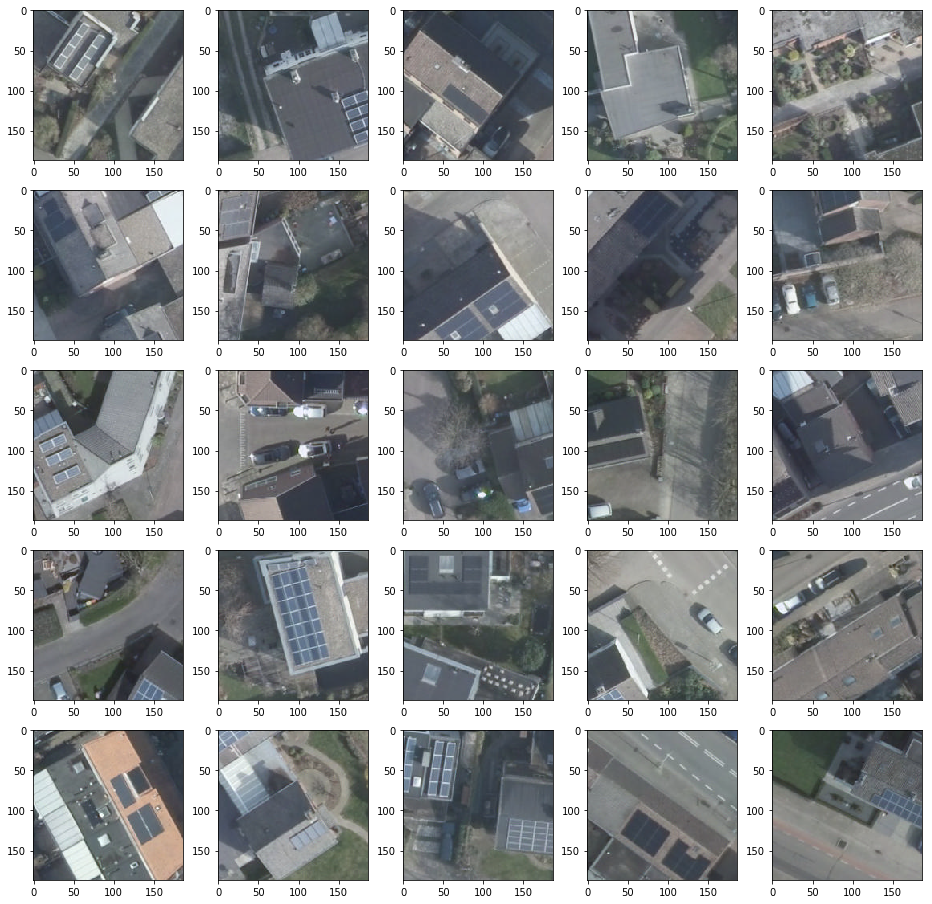

In [6]:
_, ax = plt.subplots(5,5, figsize=(16,16))

i = 0
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(hr_images[i][:,:, ::-1])      
        i += 1

In [7]:
hr_images_pre_processed = hr_images / 255

In [8]:
from sklearn.model_selection import train_test_split

train_images, test_validation_images, train_labels, test_validation_labels = train_test_split(hr_images_pre_processed, labels, test_size=0.20)
test_images, validation_images, test_labels, validation_labels = train_test_split(test_validation_images, test_validation_labels, test_size=0.50)

# Train network on HR data

We will train and evaluate the vgg16 network on the high resolution data here. For training we use:
* Image augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range = 0.1,
    zoom_range = 0.3,
    shear_range = 0.15,                                
    #brightness_range = [0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [10]:
class_weights = {
    0: 1.,
    1: train_labels[train_labels == 0].size / train_labels[train_labels == 1].size 
}

In [15]:
from keras.optimizers import SGD

batch_size = 64
epochs = 15 #100
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.9

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

In [12]:
train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [13]:
from PerformanceMetrics import PerformanceMetrics

model.compile(sgd, loss="binary_crossentropy", metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [16]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from datetime import datetime


model_name = "vgg16_heerlen_hr_batch_norm_{}".format(datetime.now().strftime("%d-%m-%Y_%H:%M:%S"))

checkpoint_dir = ProjectPaths.instance().checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.instance().file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(monitor='val_acc', patience=5)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.instance().log_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


H = model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels) // batch_size,
                    class_weight=class_weights)

Epoch 1/15


ResourceExhaustedError: OOM when allocating tensor with shape[128,128,93,93] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block2_conv2/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training/SGD/gradients/batch_normalization_3/cond/Merge_grad/cond_grad"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_3/cond/Merge, block2_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_567 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4219_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [16]:
epochs_ran = len(H.history["loss"])

_, ax = plt.subplots(1,2, figsize=(25, 10))
ax[0].plot(np.arange(0, epochs_ran), H.history["acc"], label="accuracy")
ax[0].plot(np.arange(0, epochs_ran), H.history["val_acc"], label="val_accuracy", color="r")
ax[0].set_xlim([0, epochs_ran])
ax[1].plot(np.arange(0, epochs_ran), H.history["loss"], label="loss", color="g")
ax[1].plot(np.arange(0, epochs_ran), H.history["val_loss"], label="val_loss", color="y")
ax[1].set_xlim([0, epochs_ran])
ax[0].legend()
ax[1].legend()

ax[0].set_ylabel("Loss/Accuracy")
ax[0].set_xlabel("Epochs")

ax[1].set_ylabel("Loss/Accuracy")
ax[1].set_xlabel("Epochs")

NameError: name 'H' is not defined